In [1]:
# utils
import os
import warnings
from easydict import EasyDict
from pprint import pprint

# for basic DL & viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# for Cross Vaildation & metrics
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score

# for torch
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

# pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.loggers import WandbLogger

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/data/train/new_train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18900 non-null  int64 
 1   gender      18900 non-null  int64 
 2   age         18900 non-null  int64 
 3   age_group   18900 non-null  int64 
 4   age_10      18900 non-null  int64 
 5   mask        18900 non-null  int64 
 6   path        18900 non-null  object
 7   label       18900 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.2+ MB


## Mask Config

In [16]:
batch_size = 64
num_workers = 8
epoch = 1
seed = 42

mask = {
    'n_splits': 5,
    'epoch': epoch,
    'target': 'mask',
    "model":{
        'name': "resnet18",
        'num_class': 3,
    },
    'trainer': {
        'gpus': 1,
        'accumulate_grad_batches': 1,
        'progress_bar_refresh_rate': 5,
        'fast_dev_run': False,
        'num_sanity_val_steps': 0,
        'resume_from_checkpoint': None,
    },
    'train_loader':{
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers,
        'pin_memory': False,
        'drop_last': True,
    },
    'val_loader':{
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers,
        'pin_memory': False,
        'drop_last': True,
    },
    'loss': "nn.CrossEntropyLoss",
    'optim':{
        'name': 'optim.AdamW',
        'params':{
            'lr': 1e-5
        },
    },
    'sche':{
        'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
        'params':{
            'T_0': epoch,
            'eta_min': 1e-4,
        }
    }
}

mask = EasyDict(mask)
pprint(mask)

{'epoch': 1,
 'loss': 'nn.CrossEntropyLoss',
 'model': {'name': 'resnet18', 'num_class': 3},
 'n_splits': 5,
 'optim': {'name': 'optim.AdamW', 'params': {'lr': 1e-05}},
 'sche': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
          'params': {'T_0': 1, 'eta_min': 0.0001}},
 'target': 'mask',
 'train_loader': {'batch_size': 64,
                  'drop_last': True,
                  'num_workers': 8,
                  'pin_memory': False,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 1,
             'fast_dev_run': False,
             'gpus': 1,
             'num_sanity_val_steps': 0,
             'progress_bar_refresh_rate': 5,
             'resume_from_checkpoint': None},
 'val_loader': {'batch_size': 64,
                'drop_last': True,
                'num_workers': 8,
                'pin_memory': False,
                'shuffle': True}}


### Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, target: str = None, transforms: T = None, mode: bool = True):
        self.data = df
        self.target_label = target
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data.iloc[index]
#         img = read_image(data["path"])
        img = Image.open(data["path"])
        if self.transforms:
            img = self.transforms(img)

        y = None
        if self.mode:
            y = data[self.target_label]
        return img, y

### DataLoader

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

def get_transforms():
    transform = {
        "train": T.Compose(
            [        
                T.Resize([228, 228]),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
        "val": T.Compose(
            [
                T.Resize([228, 228]),
                T.ToTensor(),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
    }
    return transform

In [7]:
class CustomDataLoader(pl.LightningDataModule):
    def __init__(self, train_df:pd.DataFrame, val_df:pd.DataFrame = None, test_df:pd.DataFrame = None, cfg = None):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.config = cfg
        self.transforms = get_transforms()
        
    def train_dataloader(self):
        train_dataset = CustomDataset(self.train_df, self.config.target, transforms=self.transforms['train'])
        return DataLoader(train_dataset, **self.config.train_loader)
    
    def val_dataloader(self):
        val_dataset = CustomDataset(self.val_df, self.config.target, transforms=self.transforms['val'])
        return DataLoader(val_dataset, **self.config.val_loader)
    
    def test_dataloader(self):
        test_dataset = CustomDataset(self.test_df, mode=False)
        return DataLoader(test_dataset, **self.config.val_loader, transforms=self.transforms['val'])

## DataLoader Test

In [8]:
sample_dataloader = CustomDataLoader(train_df=df,val_df=df, cfg=mask).val_dataloader()

In [9]:
images, labels = iter(sample_dataloader).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

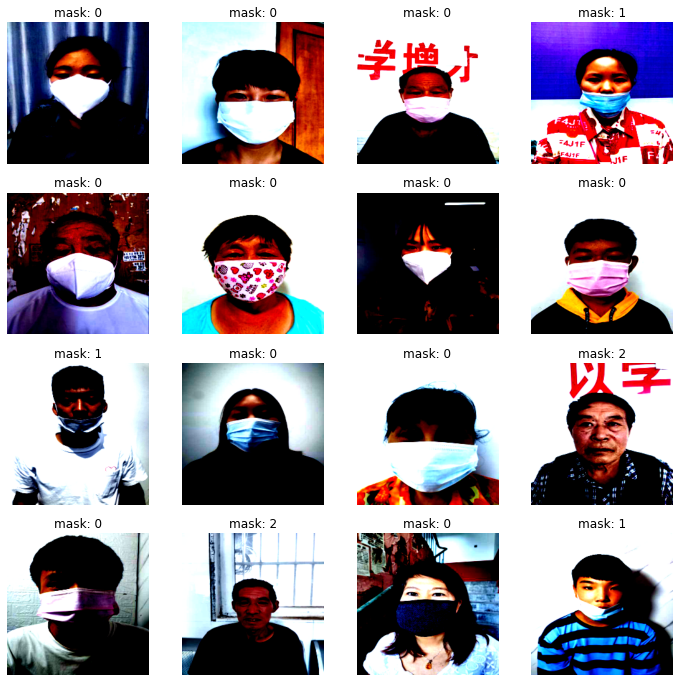

In [10]:
plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'mask: {int(label)}')

## F1 Score

In [11]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor) -> torch.Tensor:    
    y_true = F.one_hot(y_true, y_pred.shape[-1]).to(torch.float32)
    y_pred = F.one_hot(torch.argmax(y_pred, dim=1), y_pred.shape[-1]).to(torch.float32)
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    return f1

### Classification Model

In [12]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.config = cfg
        self.feature = timm.create_model(self.config.model.name, pretrained=True, num_classes=self.config.model.num_class)
        self.save_hyperparameters(cfg)
        self._criterion = eval(self.config.loss)()
        
    def forward(self, x):
        return self.feature(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.feature(x)
        loss = self._criterion(y_hat, y)
        return {"loss" : loss, "pred" : y_hat, 'labels': y}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.feature(x)
        return {"pred" : y_hat, 'labels': y}
    
    def training_epoch_end(self, outputs):
        self.__cal_metrics(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        self.__cal_metrics(outputs, 'val')
    
    def __cal_metrics(self, outputs, mode) -> None:
        """
        metrics 계산을 위한 함수
        params:
            outputs: 각 epoch에 나온 log(loss:only train_epoch, pred, labels)
            mode: train or validation?
        """
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = f1_loss(labels, preds)
        self.log(f"{mode}_f1_score", metrics)
        
        
    def configure_optimizers(self):
        optimizer = eval(self.config.optim.name)(
            self.parameters(), **self.config.optim.params)
        scheduler = eval(self.config.sche.name)(
            optimizer,
            **self.config.sche.params
        )
        return [optimizer], [scheduler]

## Cross Validation

In [13]:
seed_everything(seed)

Global seed set to 42


42

In [14]:
skf = StratifiedKFold(
    n_splits=mask.n_splits, shuffle=True, random_state=seed
)

In [17]:
for fold, (train_idx, val_idx) in enumerate(skf.split(df["Unnamed: 0"], df["mask"])):
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
    maskdatamodule = CustomDataLoader(train_df=train_df, val_df=val_df, cfg=mask)
    model = ClassificationModel(mask)
    trainer = pl.Trainer(
        max_epochs=mask.epoch,
        **mask.trainer,
    )
    trainer.fit(model, datamodule=maskdatamodule)
    break

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | feature    | ResNet           | 11.2 M
1 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Epoch 0:  81%|████████▏ | 240/295 [00:21<00:04, 11.34it/s, loss=0.0612, v_num=15]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 295/295 [00:25<00:00, 11.53it/s, loss=0.0605, v_num=15]
